In [1]:
import os
import numpy as np
import pickle
import dill
import sys
import matplotlib.pyplot as plt
from copy import deepcopy

from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0=70, Om0=0.3)
from astropy.cosmology import Planck15 as cosmo

from prospect import prospect_args
from prospect.fitting import fit_model
from prospect.io import write_results as writer
from prospect.likelihood import NoiseModel
from prospect.likelihood.kernels import Uncorrelated
from prospect.sources.galaxy_basis import CSPSpecBasis
from prospect.utils.obsutils import fix_obs
from prospect.utils.plotting import get_best

import prospect.io.read_results as reader
from toolbox_prospector import *
from Plot import *
from prospect.models import sedmodel

from sedpy.observate import load_filters
from prospect.models.sedmodel import SpecModel, LineSpecModel
from dynesty.plotting import _quantile as weighted_quantile

import Build


In [11]:
path_wdir   =   "/Users/amanda/Desktop/Paper/technical/"
path_data   =   os.path.join(path_wdir, "data/")
path_plots  =   os.path.join(path_wdir, "plots/iot_snr20/")
path_output =   os.path.join(path_wdir, "prospector/snr20/")
path_flury  =   os.path.join(path_data, 'flury/')
path_mock   =   os.path.join(path_data, 'mock/')

#------------------------------------------------------Mock Photometry----------------------------------------------------------------------

with open(path_mock + 'distorted_data.pickle', 'rb') as f:
    dis_data = pickle.load(f)

#--------------------------------------------------------Mock Thetas------------------------------------------------------------------------

with open(path_mock + 'mock_thetas.pickle', 'rb') as f:
    thetas = pickle.load(f)

#--------------------------------------------------------Results------------------------------------------------------------------------

#with open(path_data + 'eout_snr20.dat', 'rb') as f:
#    iot20 = dill.load(f)


## Create dictionary with the results

The function reads out the .h5 file, and prepares it for work, for example by delogifying some of the values. The customized function 'build_output2' creates a dictionary with all the results. THERE ARE SOME PROBLEMS WITH IT! NO SFH INFO POSSIBLE! (the problems are in the build_output function, which is in the Build.py file, something about some non fitting array lenghs.)

In [3]:
def ouput_maker(num='0'):
    res, obs, mod                   =   reader.results_from(path_output + num + '_Thetas.h5')
    model                           =   Build.build_model(objid=3)
    parnames, theta_map             =   get_best(res)
    sps                             =   reader.get_sps(res)
    
    pre_spec, pre_phot, pre_frac    =   model.predict(thetas['thetas_'+num], obs=obs, sps=sps)
    spec, phot, mfrac               =   mod.predict(theta_map, obs=obs, sps=sps)

    eout = {}
    eout['res']         =   res 
    eout['obs']         =   obs   
    eout['sps']         =   sps  
    eout['model']       =   model  
    eout['parnames']    =   parnames  
    eout['theta_map']   =   theta_map
    eout['pre_spec']    =   pre_spec
    eout['pre_phot']    =   pre_phot
    eout['spec']        =   spec
    eout['phot']        =   phot  

    ncalc               =   100
    nsample_0           =   res['chain'].shape[0]
    res['weights']     /=   np.sum(res['weights']) #normalize the probability to 1
    sample_idx          =   np.random.choice(np.arange(nsample_0), size=ncalc, p=res['weights'], replace=False) 

    trot                =   Build.build_output(res=res, mod=mod, sps=sps, obs=obs, sample_idx=sample_idx, ncalc=ncalc)
    eout |= trot 

    return eout

Loop over every single theta vector we gave as an input to get everything we need for the plotting:

In [ ]:
theta_name      =   ['0',  '1',  '2',  '3',  '4',  '5',  '6']
names           =   ['eout_0',  'eout_1',   'eout_2',   'eout_3',   'eout_4',   'eout_5',   'eout_6']

#theta_name      =   ['7', '8', '9', '10', '11', '12']
#names           =   ['eout_7',  'eout_8',   'eout_9',   'eout_10',   'eout_11',   'eout_12']

iot20 = {}

for tn,e in zip(theta_name, names):

    iot20[e]    =   ouput_maker(num=tn)
    print('Done with ' + e + ', theta name ' + tn )


## Save
Save the output of the looping in a file, so we do not have to do this everytime, because it takes around 17 minutes. Pickle was not possible, so I have to dill it instead.

In [10]:
filename = path_data + 'eout_snr20.dat'

with open(filename, 'wb') as f:
    dill.dump(iot20, f)

## Plot the Escape Fraction

This input output test focusses on the escape fraction as the variable parameter. Here we read in all the data into list we need to plot the relationship between them.

1. fill the empty list with the values from the dictionaries inside the dictionary we just created
2. plot everything with errorbars and save

In [213]:
frac_esc_in     =   []
frac_esc_out    =   []
lolims          =   []
uplims          =   []

theta_name      =   ['0',  '1',  '2',  '3',  '4',  '5',  '6']
eout_id         =   ['eout_0',  'eout_1',   'eout_2',   'eout_3',   'eout_4',   'eout_5',   'eout_6']

for i,e in zip(theta_name, eout_id):
    frac_esc_in.append(thetas['thetas_'+i][15])
    frac_esc_out.append(iot20[e]['thetas']['frac_obrun']['q50'])
    lolims.append(iot20[e]['thetas']['frac_obrun']['q50']   -   iot20[e]['thetas']['frac_obrun']['q16'])
    uplims.append(iot20[e]['thetas']['frac_obrun']['q84']   -   iot20[e]['thetas']['frac_obrun']['q50'])

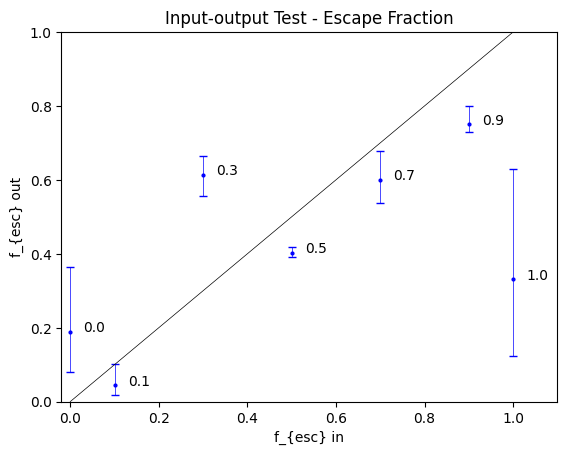

In [16]:
x       =   np.linspace(0,1, 1000)
name    =   ['0.0', '0.1', '0.3', '0.5', '0.7', '0.9', '1.0']

plt.errorbar(frac_esc_in, frac_esc_out, yerr=(lolims, uplims), linestyle = '', color='b', marker = "o", capsize=3, lw=0.5, ms=2)

for i in range(len(frac_esc_in)):
    plt.text(frac_esc_in[i]+0.03, frac_esc_out[i], name[i])

plt.plot(x,x, color='k', lw=0.5)
plt.xlim(-0.02,1.1)
plt.ylim(0, 1.)
plt.xlabel("f_{esc} in")
plt.ylabel('f_{esc} out')
plt.title('Input-output Test - Escape Fraction')
plt.savefig(path_plots+"iot_snr_20.png")

In [215]:
np.round(frac_esc_out,2)

array([0.19, 0.04, 0.61, 0.4 , 0.6 , 0.75, 0.33])